In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from Transformer import PositionalEncoding, TransformerEncoder

In [4]:
from mymodule.DatabaseConnection import CRUD
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
import importlib
import mymodule.DatabaseConnection  # first import
importlib.reload(mymodule.DatabaseConnection) 

<module 'mymodule.DatabaseConnection' from 'c:\\Projects\\Market\\mymodule\\DatabaseConnection.py'>

In [6]:
lo_stockdailyupdate = CRUD('stockdailyupdate',schema=None)

In [50]:
df = lo_stockdailyupdate.Read(where="Symbol='VEDL'")

In [ ]:
column_selector = ColumnSelector(columns=["Customer_Type", "Gender", "Age"])

In [51]:
# Sort by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

In [52]:
df["LDCPABOVE5DMA"]   = np.where(df["open"] > df["close"].rolling(5).mean(),1,0)
df["LDCPABOVE20DMA"]  = np.where(df["open"] > df["close"].rolling(20).mean(),1,0)
df["LDCPABOVE100DMA"] = np.where(df["open"] > df["close"].rolling(100).mean(),1,0)
df["LDCPABOVE200DMA"] = np.where(df["open"] > df["close"].rolling(200).mean(),1,0)

In [53]:
df

,StockExchange,Symbol,Date,open,high,low,close,volume,delivery,LDCPABOVE5DMA,LDCPABOVE20DMA,LDCPABOVE100DMA,LDCPABOVE200DMA
0,NSE,VEDL,2000-11-13,0.285761,0.285761,0.277940,0.285159,103440,0,0,0,0,0
1,NSE,VEDL,2000-11-14,0.284859,0.300801,0.277639,0.294785,384080,0,0,0,0,0
2,NSE,VEDL,2000-11-15,0.302305,0.318548,0.289371,0.290875,167600,0,0,0,0,0
3,NSE,VEDL,2000-11-16,0.275835,0.300801,0.275835,0.294785,208320,0,0,0,0,0
4,NSE,VEDL,2000-11-17,0.288769,0.303809,0.288769,0.303809,275680,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6236,NSE,VEDL,2025-11-24,498.150000,503.500000,493.800000,495.150000,10371411,0,0,0,1,1
6237,NSE,VEDL,2025-11-25,495.600000,506.850000,495.600000,504.650000,7658295,0,0,0,1,1
6238,NSE,VEDL,2025-11-26,507.900000,517.000000,506.100000,516.300000,7777469,0,1,0,1,1
6239,NSE,VEDL,2025-11-27,518.700000,523.750000,517.350000,519.100000,5978457,0,1,1,1,1


In [16]:
df.columns

Index(['StockExchange', 'Symbol', 'Date', 'open', 'high', 'low', 'close',
       'volume', 'delivery', '20DMA', '50DMA', '100DMA', '200DMA'],
      dtype='object')

In [17]:
features = ['open', 'high', 'low', 'close', 'volume'] #, '20DMA', '50DMA', '100DMA', '200DMA'] #, 'RSI', ]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

scaled_df = pd.DataFrame(scaled_data, columns=features, index=df.index)

In [18]:
scaled_df

,open,high,low,close,volume
11037269,0.000073,0.000072,0.000058,0.000071,0.000310
11037270,0.000071,0.000100,0.000058,0.000090,0.001152
11037271,0.000104,0.000133,0.000080,0.000082,0.000503
11037272,0.000054,0.000100,0.000054,0.000090,0.000625
11037273,0.000078,0.000105,0.000079,0.000107,0.000827
...,...,...,...,...,...
11043505,0.943439,0.940215,0.941979,0.934921,0.031113
11043506,0.938608,0.946474,0.945415,0.952867,0.022974
11043507,0.961914,0.965437,0.965455,0.974875,0.023332
11043508,0.982378,0.978048,0.986926,0.980164,0.017935


In [19]:
lookback = 60
X, y = [], []

for i in range(lookback, len(scaled_df)):
    X.append(scaled_df.iloc[i-lookback:i].values)
    y.append(scaled_df.iloc[i]['close'])

X, y = np.array(X), np.array(y)

print("X shape:", X.shape)  # (samples, timesteps=60, features)
print("y shape:", y.shape)  # (samples,)

X shape: (6181, 60, 5)
y shape: (6181,)


In [20]:
X[0][59]

array([0.0006341 , 0.00064489, 0.00060713, 0.00061344, 0.00535487])

In [21]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling1D

sequence_length = X_train.shape[1]
feature_dim = X_train.shape[2]
embed_dim = 64
num_heads = 4
ff_dim = 128

inputs = Input(shape=(sequence_length, feature_dim))
x = Dense(embed_dim)(inputs)
x = PositionalEncoding(sequence_length, embed_dim)(x)
x = TransformerEncoder(embed_dim, num_heads, ff_dim)(x)
x = Dropout(0.2)(x)
x = GlobalAveragePooling1D()(x)
x = Dense(16, activation="relu")(x)
outputs = Dense(1)(x)  # Regression output

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer="adam",
    loss="mean_squared_error"
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 60, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding_1           │ (None, 60, 64)         │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 60, 64)         │        83,200 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,641 (330.63 KB)

 Trainable params: 84,641 (330.63 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0500 - val_loss: 0.0022
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0040 - val_loss: 0.0119
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0034 - val_loss: 3.8727e-04
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0021 - val_loss: 2.7322e-04
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0018 - val_loss: 9.3797e-04
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0013 - val_loss: 2.3374e-04
Epoch 9/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0010 - val_loss: 7.3003e-05
Epoch 10/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 8.7069e-04 - val_loss: 4.2399e-04
Epoch 11/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 6.8824e-04 - val_loss: 3.697

In [31]:
model.save("./models/transformer_model_vedl.keras")

In [2]:
from tensorflow.keras.models import load_model

model = load_model(
    "./models/transformer_model_vedl.keras",
    custom_objects={
        "PositionalEncoding": PositionalEncoding,
        "TransformerEncoder": TransformerEncoder
    }
)

c:\Projects\Market\venv\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'transformer_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


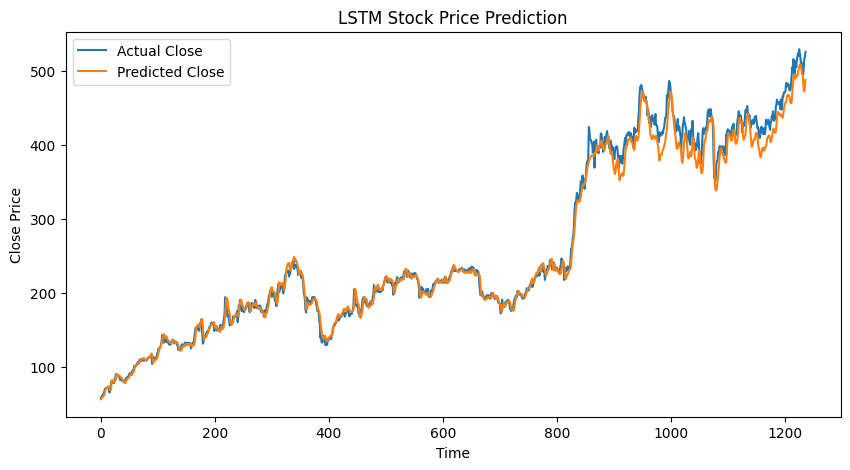

In [30]:
import matplotlib.pyplot as plt

# Predictions
y_pred = model.predict(X_test)

# Inverse scale for interpretability
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[features.index('close')], scaler.scale_[features.index('close')]
y_test_inv = y_test / close_scaler.scale_ - close_scaler.min_ / close_scaler.scale_
y_pred_inv = y_pred / close_scaler.scale_ - close_scaler.min_ / close_scaler.scale_

# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual Close')
plt.plot(y_pred_inv, label='Predicted Close')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
import numpy as np

mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)
#accuracy = accuracy_score(y_test, y_pred)

print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

MSE : 155.1230
RMSE: 12.4548
MAE : 8.3879
R²  : 0.9896


In [24]:
y_pred

array([[ 0.10674602],
       [ 0.11007996],
       [ 0.1109815 ],
       ...,
       [-1.4575926 ],
       [-1.4865328 ],
       [-1.5105482 ]], shape=(1237, 1), dtype=float32)

In [25]:
y_test

array([0.11072582, 0.11146238, 0.11385662, ..., 0.97487497, 0.98016445,
       0.99319924], shape=(1237,))

In [26]:
y_test_inv

array([ 58.8604,  59.2503,  60.5177, ..., 516.3   , 519.1   , 526.    ],
      shape=(1237,))

In [34]:
y_pred_inv[-1]

array([488.12326359])

In [35]:
X_test.shape

(1237, 60, 5)

In [36]:
X_train.shape

(4944, 60, 5)

In [41]:
df['Date'].min()

Timestamp('2000-11-13 00:00:00')

In [42]:
df['Date'].max()

Timestamp('2025-11-28 00:00:00')